Mit Zufallsvariablen
$$
\begin{align}
X' &: \Omega \rightarrow \{0,1\} & \text{Infektion}\\
X &: \Omega \rightarrow \{0,1\} & \text{Testergebnis}
\end{align}
$$
Ist die Prävalenz $P(X'=1)$, die Sensitivität $s_+=P(X=1 \vert X'=1)$ und die Spezifizität $s_-=P(X=0 \vert X'=0)$.

Die Wahrscheinlichkeit eines positiven Testergebnisses ist 
$$
\begin{align}
P(X=1) & = P(X=1 \vert X'=1) P(X'=1) + P(X=1 \vert X'=0) P(X'=0) \\
       & = s_+ P(X'=1) + \left(1-s_-\right) \left(1-P(X'=1) \right) \\
       & = s_+ P(X'=1) + 1-P(X'=1) - s_- + s_- P(X'=1)\\
       & = P(X'=1)\left( s_+ - 1 + s_- \right) + 1 - s_-\\
P(X=1) - 1 + s_-      & = P(X'=1)\left( s_+ - 1 + s_- \right)\\
P(X'=1)& = \frac{P(X=1) - 1 + s_-}{ s_+ - 1 + s_- }
\end{align}
$$

In [123]:
sensitivity, specificity = .99, .97
sensitivity, specificity = .89, .94
prevalence = .005

0.005

In [2]:
# Import libraries.
using Turing, StatsPlots, Random
?Binomial

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


LoadError: syntax: invalid identifier name "?"

In [136]:
N_test, N_pos =  382154, 10187
( (N_pos/N_test) - 1 + specificity) / (sensitivity-1+specificity)

-0.040172538781596344

In [59]:
?HMC

search: HMC HMCDA SGHMC eachmatch Hypergeometric NoncentralHypergeometric



```
HMC(ϵ::Float64, n_leapfrog::Int)
```

Hamiltonian Monte Carlo sampler with static trajectory.

Arguments:

  * `ϵ::Float64` : The leapfrog step size to use.
  * `n_leapfrog::Int` : The number of leapfrop steps to use.

Usage:

```julia
HMC(0.05, 10)
```

Tips:

  * If you are receiving gradient errors when using `HMC`, try reducing the

`step_size` parameter, e.g.

```julia
# Original step_size
sample(gdemo([1.5, 2]), HMC(0.1, 10), 1000)

# Reduced step_size.
sample(gdemo([1.5, 2]), HMC(0.01, 10), 1000)
```


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


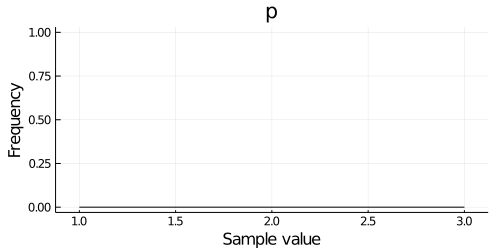

In [147]:
# Declare our Turing model.
@model pcretests(y) = begin
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1,1)#prevalence*N, N*(1-prevalence))
    q = p * sensitivity + (1-p) * (1-specificity)
    # The number of observations.
    y ~ Binomial(N_test,q)
end;

# Start sampling.
chain = sample(pcretests(N_pos), HMC( 0.01,100), 10000);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/gregor/.julia/packages/Turing/q3coT/src/inference/hmc.jl:553
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


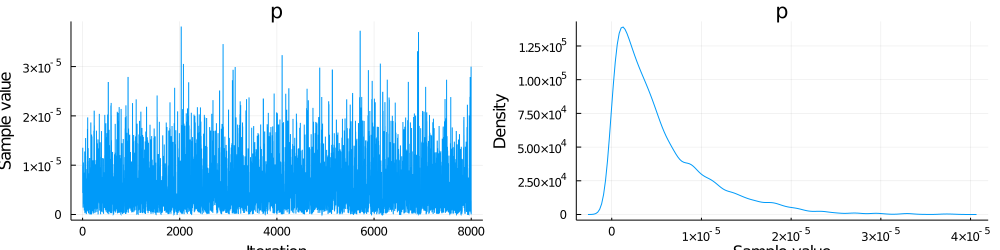

In [151]:
chain = sample(pcretests(N_pos), NUTS( 2000, 0.65), 10000);
plot(chain)


In [138]:

# Set the true probability of heads in a coin.
p_true = prevalence

# Iterate from having seen 0 observations to 100 observations.

# Draw data from a Binomial distribution, i.e. draw N .
Random.seed!(13)
data = vcat([ 1 for _ in 1:N_pos ],[ 0 for _ in 1:(N_test-N_pos) ])
# Declare our Turing model.
@model pcretests(M,y) = begin
    # Our prior belief about the probability of heads in a coin.
    prevalences = tzeros(Float64,M)
    for m in 1:M
        prevalences[m] ~ Beta(1,1)#prevalence*N, N*(1-prevalence))
    end
    group = tzeros(Int,length(y))
    ps ~ Dirichlet(ones(M))
    for i in 1:N_test
        group[i] = rand(Categorical(ps))
        p = prevalences[group[i]]
        q = p * sensitivity + (1-p) * (1-specificity)
        y[i] ~ Bernoulli(q)
    end
end;

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 100000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(pcretests(2,data), NUTS( 0.65), iterations);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Warning: `find_good_eps` is deprecated, use `find_good_stepsize` instead.
│   caller = #HMCState#52(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Type{Turing.Inference.HMCState}, ::DynamicPPL.Model{var"##inner_function#2293#144",NamedTuple{(:M, :y),Tuple{Int64,Array{Int64,1}}},DynamicPPL.ModelGen{(:M, :y),var"###pcretests#2313",NamedTuple{(),Tuple{}}},Val{()}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:prevalences, :ps),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:prevalences},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:prevalences},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ps},Int64},Array{Dirichlet{Float64},1},Array{DynamicPPL.VarName{:ps},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}, ::Random._GLOBAL_RNG) at hmc.jl:552
└ @ Turing.Inference /home/

TypeError: TypeError: in typeassert, expected Float64, got ForwardDiff.Dual{Nothing,Float64,4}

In [140]:
?Bernoulli

search: Bernoulli



```
Bernoulli(p)
```

A *Bernoulli distribution* is parameterized by a success rate `p`, which takes value 1 with probability `p` and 0 with probability `1-p`.

$$
P(X = k) = \begin{cases}
1 - p & \quad \text{for } k = 0, \\
p & \quad \text{for } k = 1.
\end{cases}
$$

```julia
Bernoulli()    # Bernoulli distribution with p = 0.5
Bernoulli(p)   # Bernoulli distribution with success rate p

params(d)      # Get the parameters, i.e. (p,)
succprob(d)    # Get the success rate, i.e. p
failprob(d)    # Get the failure rate, i.e. 1 - p
```

External links:

  * [Bernoulli distribution on Wikipedia](http://en.wikipedia.org/wiki/Bernoulli_distribution)


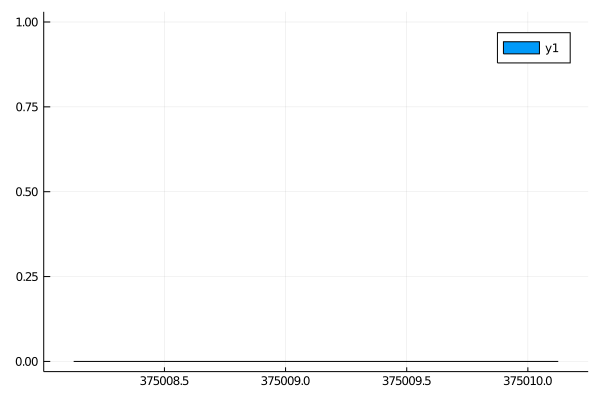

In [144]:
histogram(N_test*get(chain,:p).p.data)

In [134]:


# Declare our Turing model.
@model pcretests(y) = begin
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1, 1)

    # The number of observations.
    infected ~ Binomial(N,p)
    true_pos ~ Binomial(infected,sensitivity)
    false_pos ~ Binomial(N-infected,1-specificity)
    y = true_pos + false_pos
end;

# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
chain = sample(pcretests(data), NUTS(0.65), iterations);

# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Warning: `find_good_eps` is deprecated, use `find_good_stepsize` instead.
│   caller = #HMCState#52(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Type{Turing.Inference.HMCState}, ::DynamicPPL.Model{var"##inner_function#2170#130",NamedTuple{(:y,),Tuple{Int64}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2196",NamedTuple{(),Tuple{}}},Val{()}}, ::DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},A

MethodError: MethodError: no method matching _logpdf_with_trans(::Binomial{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"##inner_function#2170#130",NamedTuple{(:y,),Tuple{Int64}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2196",NamedTuple{(),Tuple{}}},Val{()}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}},Float64},Float64,4}}, ::ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"##inner_function#2170#130",NamedTuple{(:y,),Tuple{Int64}},DynamicPPL.ModelGen{(:y,),var"###pcretests#2196",NamedTuple{(),Tuple{}}},Val{()}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.SamplerState{DynamicPPL.VarInfo{NamedTuple{(:p, :infected, :true_pos, :false_pos),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:p},Int64},Array{Beta{Float64},1},Array{DynamicPPL.VarName{:p},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:infected},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:infected},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:true_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:true_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:false_pos},Int64},Array{Binomial{Float64},1},Array{DynamicPPL.VarName{:false_pos},1},Array{Int64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64}}}},Float64},Float64,4}, ::Bool)
Closest candidates are:
  _logpdf_with_trans(!Matched::Union{Kolmogorov, BetaPrime, Chi, Chisq, Erlang, Exponential, FDist, Frechet, Gamma, InverseGamma, InverseGaussian, LogNormal, NoncentralChisq, NoncentralF, Rayleigh, Weibull}, ::Real, ::Bool) at /home/gregor/.julia/packages/Bijectors/kgZvw/src/Bijectors.jl:232
  _logpdf_with_trans(!Matched::Union{KSOneSided, Beta, NoncentralBeta}, ::Real, ::Bool) at /home/gregor/.julia/packages/Bijectors/kgZvw/src/Bijectors.jl:245
  _logpdf_with_trans(!Matched::Union{Truncated{T,S,T1} where T1<:Real where S<:ValueSupport, T} where T<:Distribution{Univariate,Continuous}, ::Real, ::Bool) at /home/gregor/.julia/packages/Bijectors/kgZvw/src/Bijectors.jl:204

In [5]:
using Pkg
Pkg.add("MCMCChains")

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
  [c7f686f2] + MCMCChains v3.0.12
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
